In [1]:
import csv, math
from math import exp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def write_to_csv(ls, filename):
    df = pd.DataFrame(ls)
    df.to_csv(filename, index=None, header=None)

In [3]:
# g: list of G(0), ..., G(t)
# g_target: set point of glucose level
def pid_controller(g, g_target, prev_sum):
    et_1 = g[1] - g_target
    et_2 = g[0] - g_target
    
    u0 = 16.67
    Kp = 0.5
    Ki_tor_i = 0.01
    Kd = 0.05
    
    cur_sum = et_1 + prev_sum
    
    # Calculate u(t) using PID based on errors
    ut = u0 + Kp * et_1 + Ki_tor_i * cur_sum + Kd * (et_1 - et_2)
    
    # Remove negative u(t)
    if ut < 0:
        ut=0
    
    return (ut, cur_sum)

In [4]:
# Human Glucose - Insulin System Model by Bergman 1981
# A simple 3 equation model.

# States = [Plasma Glucose(G), 
#           Plasma Insulin Remote Compartment(X), 
#           Plasma Insulin(I)]

def bergman_minmod(x, U, D):
    
    # Get the last G(t), X(t) and I(t)
    G=x[-1][0]
    X=x[-1][1]
    I=x[-1][2]
    
    # Parameters
    Gb=4.5
    Xb=15
    Ib=15
    
    # For T1D, in some papers P1 = 0 to T1D
    P1=0.028735
    P2=0.028344
    P3=5.035e-05
    V1=12
    n=5 / 54
    
    # Minimal Model
    Gdt = -P1 * (G - Gb) - (X - Xb) * G + D
    Xdt = -P2 * (X - Xb) + P3 * (I - Ib)
    Idt = -n * I + U / V1
    
    dx_dt = [Gdt, Xdt, Idt]
    return dx_dt

In [5]:
# Create meal profile to simulate one afternoon of diabetes patient
def meal_profile(t):
    if t < 100:
        m = 0
    # Lunch
    elif t >= 100 and t < 9000:
        m = 2 * exp(-0.001 * (t-100))
    # Snack
    elif t >= 9000 and t < 16000:
        m = 1 * exp(-0.001 * (t-9000))
    # Dinner
    elif t >= 16000 and t < 21600:
        m = 2 * exp(-0.001 * (t-16000))
    else:
        m = 0

    return m

In [6]:
def get_column(x, index):
    result = []
    for i in range(len(x)):
        result.append(x[i][index])
    return result

In [7]:
# Simulate one afternoon of a patient's life
# 6*60*60 = 21600 seconds
tend = 21600
tspan = [i for i in range(tend)]

# Set up initial conditions
x0 = x1 = [4.5, 15, 15]
x = [x0, x1]

# Set point of blood glucose level
g_target = 6

# Meal profiles
m = []
for t in tspan:
    m.append(meal_profile(t))


prev_sum = 0

# Simulation
for t in tspan:
    gt1 = x[-1][0]
    gt2 = x[-2][0]
    
    g = [gt2, gt1]
    
    tup = pid_controller(g, g_target, prev_sum)
    
    ut = tup[0]
    prev_sum = tup[1]
    
    dx_dt = bergman_minmod(x, ut, m[t])
    
    # x(t) = x(t-1) + dx/dt
    xt = [x[-1][i] + dx_dt[i] for i in range(len(dx_dt))]
    
    # Append xt to x
    x.append(xt)
    
# Display the list of G(t), X(t) and I(t)
x

[[4.5, 15, 15],
 [4.5, 15, 15],
 [4.5, 15.0, 14.936527777777778],
 [4.5, 14.99999680417361, 14.877682613168725],
 [4.500014381218752, 14.999990736075686, 14.82303607491236],
 [4.50005565576707, 14.99998208851873, 14.772200072432906],
 [4.500134659161198, 14.999971126475401, 14.72482298542826],
 [4.50026072447898, 14.999958089703899, 14.680586226966438],
 [4.500441839820572, 14.999943195125859, 14.639201130741812],
 [4.500684790585619, 14.999926638980144, 14.600406131918835],
 [4.50099528795443, 14.999908598773633, 14.563964213871465],
 [4.501378084844251, 14.999889235048162, 14.529660595736326],
 [4.501837080503024, 14.999868692980952, 14.497300638062077],
 [4.50237541480205, 14.999847103834226, 14.46670794597948],
 [4.502995553195514, 14.999824586268229, 14.43772265125699],
 [4.503699363228575, 14.999801247530533, 14.410199856364368],
 [4.504488183396382, 14.999777184533295, 14.384008225258814],
 [4.505362885083336, 14.999752484829026, 14.35902870705027],
 [4.506323928245269, 14.99972

In [8]:
# Ignore the initial conditions
x = x[2:]
# Select G(t), X(t) and I(t)
G = get_column(x, 0)
X = get_column(x, 1)
I = get_column(x, 2)

# Set the thresholds
glucose_high = 8.3
glucose_low = 4.4

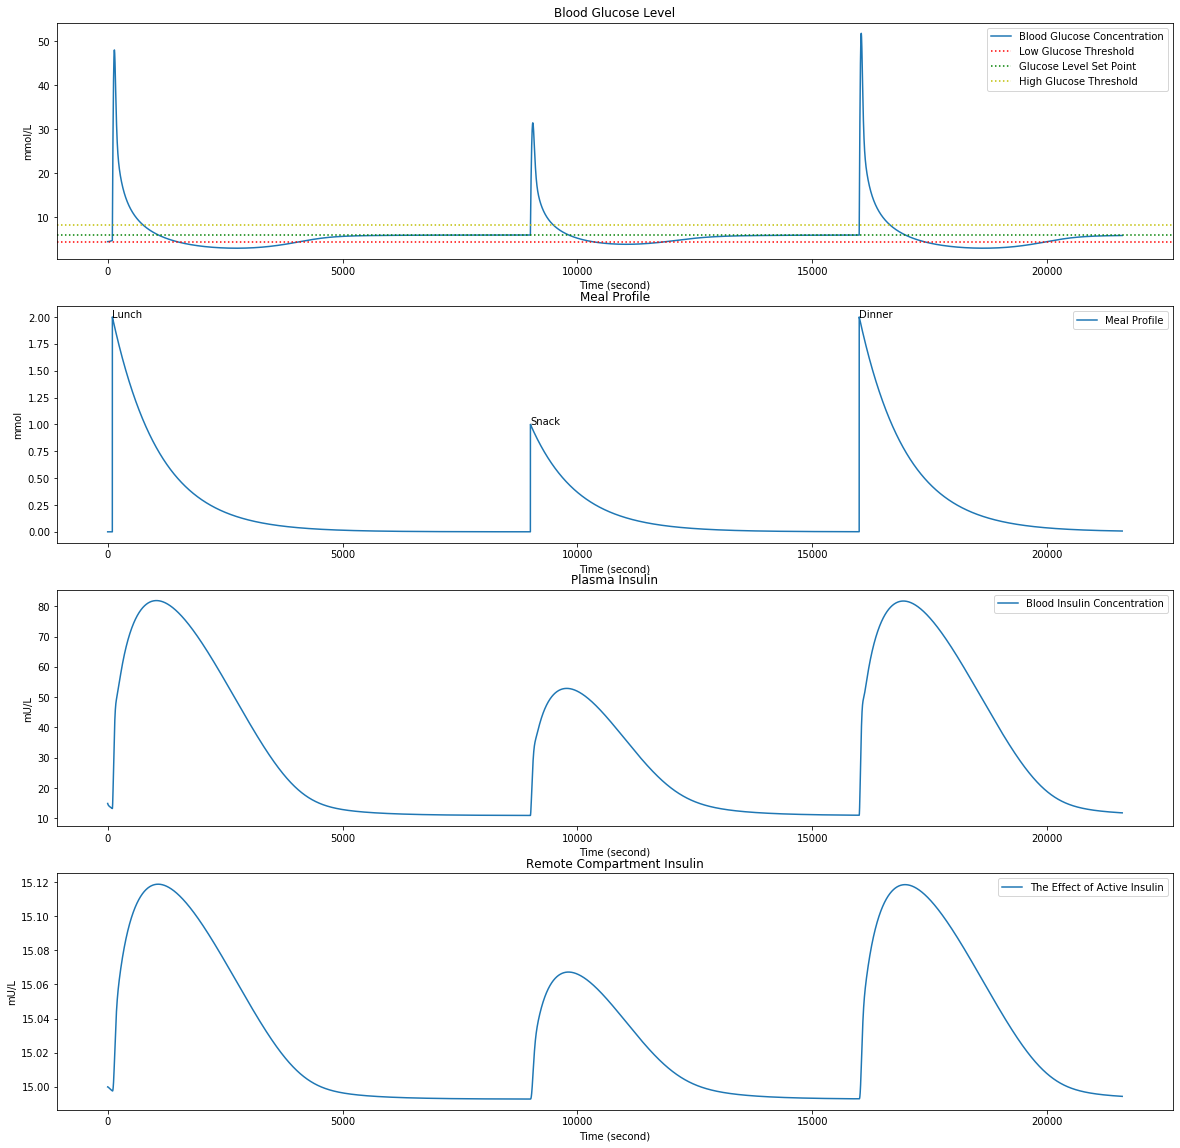

In [9]:
# Visulisation
plt.figure(figsize=(20, 20))
plt.subplot(4,1,1)
plt.plot(tspan,G, label='Blood Glucose Concentration')
plt.axhline(y = glucose_low, color = 'r', linestyle = ':', label='Low Glucose Threshold')
plt.axhline(y = g_target, color = 'g', linestyle = ':', label='Glucose Level Set Point')
plt.axhline(y = glucose_high, color = 'y', linestyle = ':', label='High Glucose Threshold')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mmol/L')
plt.title('Blood Glucose Level')

plt.subplot(4,1,2)
plt.text(100, 2, 'Lunch')
plt.text(9000, 1, 'Snack')
plt.text(16000, 2, 'Dinner')
plt.plot(tspan, m, label='Meal Profile')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mmol')
plt.title('Meal Profile')

plt.subplot(4,1,3)
plt.plot(tspan, I, label='Blood Insulin Concentration')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mU/L')
plt.title('Plasma Insulin')

plt.subplot(4,1,4)
plt.plot(tspan, X, label='The Effect of Active Insulin')
plt.legend()
plt.xlabel('Time (second)')
plt.ylabel('mU/L')
plt.title('Remote Compartment Insulin')

plt.show()

In [11]:
write_to_csv(G, '../data/pid_bergman_recursive_plaintext_G.csv')
write_to_csv(X, '../data/pid_bergman_recursive_plaintext_X.csv')
write_to_csv(I, '../data/pid_bergman_recursive_plaintext_I.csv')